In [3]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print(path)

100%|██████████| 612M/612M [00:21<00:00, 29.2MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [4]:
!mv /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/ /content/gtsrb

In [5]:
import torch
device = torch.device("cuda")

In [6]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Загрузка и подготовка набора данных
def load_gtsrb_data(data_dir):
    images = []
    labels = []
    for label in range(43):
        class_dir = os.path.join(data_dir, str(label))
        if not os.path.exists(class_dir):
            print(f"Папка {class_dir} не найдена. Пропускаем...")
            continue
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

data_dir = "/content/gtsrb/1/train"

# Загрузка данных
images, labels = load_gtsrb_data(data_dir)

# Разделение на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encoding меток классов
y_train = to_categorical(y_train, num_classes=43)
y_val = to_categorical(y_val, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

print(f"Размеры: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

Размеры: X_train=(27446, 32, 32, 3), X_val=(5881, 32, 32, 3), X_test=(5882, 32, 32, 3)


In [7]:
# Для уменьшения времени работы проведем обучение лишь на ограниченной выборке из 2500 штук
small_X_train = X_train[:2500]
small_y_train = y_train[:2500]

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers, optimizers

# Загрузка VGG16 с предобученными весами
base_model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
x = layers.Flatten()(base_model_vgg.output)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(43, activation="softmax")(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)

# Компиляция модели
model_vgg.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Обучение
history_vgg = model_vgg.fit(
    small_X_train, small_y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.0555 - loss: 3.6816 - val_accuracy: 0.0735 - val_loss: 3.4446
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 368s 4s/step - accuracy: 0.0768 - loss: 3.4336 - val_accuracy: 0.1083 - val_loss: 3.2183
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.1113 - loss: 3.1569 - val_accuracy: 0.1076 - val_loss: 3.2687
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.1416 - loss: 3.0444 - val_accuracy: 0.1371 - val_loss: 3.0170
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - accuracy: 0.1490 - loss: 2.8471 - val_accuracy: 0.1541 - val_loss: 2.6610


In [10]:
from tensorflow.keras.applications import ResNet50

# Загрузка ResNet50 с предобученными весами
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
x = layers.Flatten()(base_model_resnet.output)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(43, activation="softmax")(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

# Компиляция модели
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Обучение
history_resnet = model_resnet.fit(
    small_X_train, small_y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.1880 - loss: 3.4593 - val_accuracy: 0.0461 - val_loss: 100.3600
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.4360 - loss: 1.9744 - val_accuracy: 0.0536 - val_loss: 12.2462
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.5273 - loss: 1.5580 - val_accuracy: 0.0394 - val_loss: 3.8499
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6329 - loss: 1.2770 - val_accuracy: 0.0542 - val_loss: 7.8739
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.7469 - loss: 0.8511 - val_accuracy: 0.0092 - val_loss: 14.8168


VGG16 - Тестовая точность: 0.16, Тестовая потеря: 2.65
ResNet50 - Тестовая точность: 0.01, Тестовая потеря: 14.85


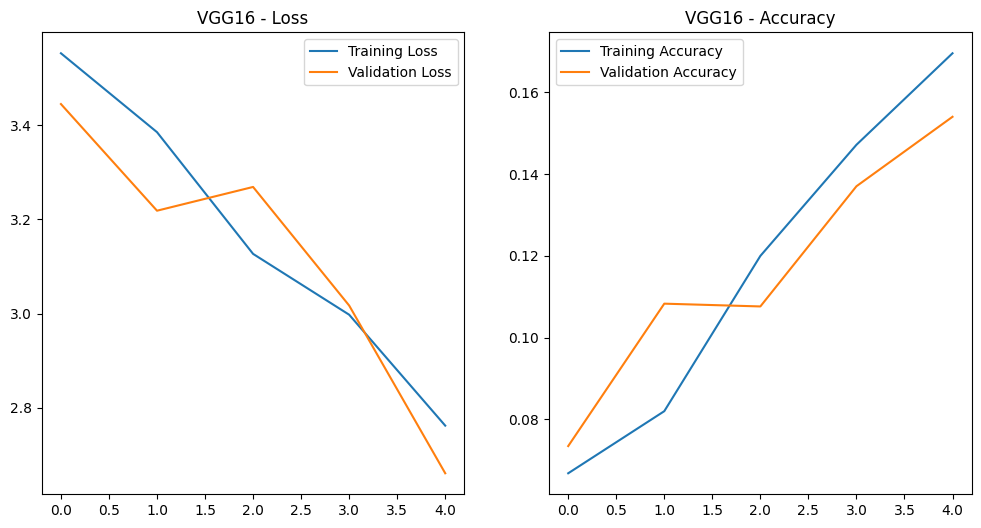

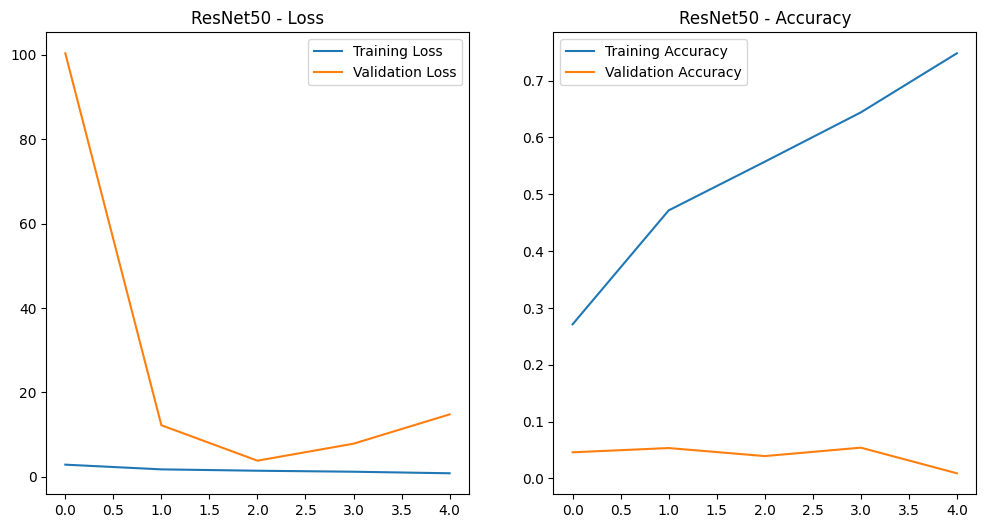

In [11]:
# Оценка моделей
vgg_eval = model_vgg.evaluate(X_test, y_test, verbose=0)
resnet_eval = model_resnet.evaluate(X_test, y_test, verbose=0)

print(f"VGG16 - Тестовая точность: {vgg_eval[1]:.2f}, Тестовая потеря: {vgg_eval[0]:.2f}")
print(f"ResNet50 - Тестовая точность: {resnet_eval[1]:.2f}, Тестовая потеря: {resnet_eval[0]:.2f}")

# Построение графиков функции потерь и точности
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.show()

plot_history(history_vgg, "VGG16")
plot_history(history_resnet, "ResNet50")

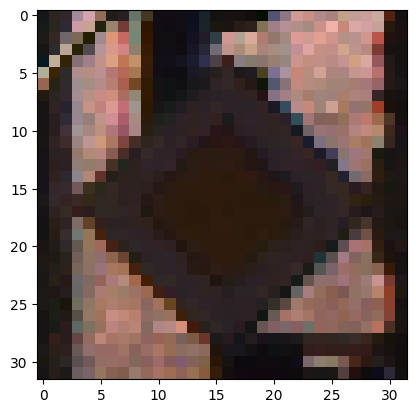

In [12]:
def fgsm_attack(model, image, label, epsilon=0.01):
    image = tf.convert_to_tensor([image], dtype=tf.float32)
    label = tf.convert_to_tensor([label], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbation = epsilon * tf.sign(gradient)
    adversarial_image = tf.clip_by_value(image + perturbation, 0, 1)
    return adversarial_image[0]

# Пример атаки на одно изображение
adv_image = fgsm_attack(model_vgg, X_test[0], y_test[0])
plt.imshow(adv_image.numpy())

In [13]:
# Проверка эффективности FGSM-атак на ResNet50
for i in range(10):  # Пример из 10 изображений
    adv_image = fgsm_attack(model_vgg, X_test[i], y_test[i])
    pred_resnet = np.argmax(model_resnet.predict(tf.convert_to_tensor([adv_image])))
    true_label = np.argmax(y_test[i])
    print(f"Истинный класс: {true_label}, Предсказание ResNet50: {pred_resnet}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Истинный класс: 12, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Истинный класс: 10, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Истинный класс: 10, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Истинный класс: 25, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
Истинный класс: 3, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Истинный класс: 28, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Истинный класс: 33, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Истинный класс: 1, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Истинный класс: 30, Предсказание ResNet50: 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Истинный класс: 11, Предсказание ResNet50: 40
